<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/main/SCM290_Week4_TourSustainable_Consolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools

# Problem
Every day (i.e. every round), the company has incoming and expected orders for the whole planning horizon (see Delivery Map and Table for more details). Based on this information, you are to choose every day to either deliver an order or postpone it. Every day that you make a decision, the company will receive new incoming orders and also defined new expected orders for the following days. 

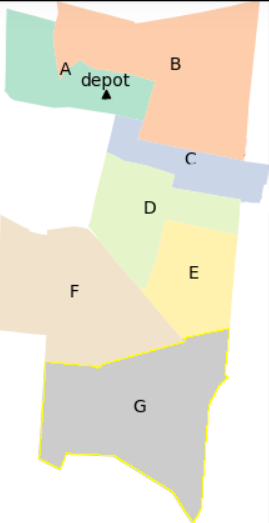

Measures done with https://imagej.nih.gov/

| R | AREA | Centroid X | Centroid Y |
| --- | --- | --- | --- |
| 1 | 5042 | 53.089 | 59.872 |
| 2 | 12377 | 141.495 | 55.948 |
| 3 | 3491 | 153.188 | 132.065 |
| 4 | 5983 | 120.959 | 170.961 |
| 5 | 5068 | 156.296 | 222.992 |
| 6 | 10909 | 60.950 | 238.262 |
| 7 | 13206 | 112.610 | 329.386 |


# Solution Approach
At each period, we have an estimation of the number of delivery points that we have to deliver  on next periods on each Region (A, B, c...) . We don't know exactly where the demand will occur so have to rely on an estimation of the hauling and local routing distance. 
We compute the routes to these regions and for various number of demand stops. We compute them also route for 2 adjacent regions (A+B, B+C, ...)
So as to minimize the CO2 emission, we will try to fill the trucks at least at 90% of their capacity.

We then define a classical Mixed INteger Linear Programming Model with decision variables for defining 
- if a route is activated for each period
- if a demand node will be served by a route (one and only one route per demand node)

The objective is to minimize the total distance


In [36]:
from ortools.sat.python import cp_model
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

INFINITY = cp_model.INT32_MAX
model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_resultarray=np.vectorize(lambda v:solver.Value(v))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')


# Region, Area (pixel^2), X, Y
Depot=(86, 77)

Regions = {
  'A': [5042,  ['A'],  (53.089, 59.872)],
  'B': [12377, ['B'], (141.495, 55.948)],
  'C': [3491,  ['C'], (153.188,	132.065)],
  'D': [5983,	 ['D'], (120.959,	170.961)],
  'E': [5068,	 ['E'], (156.296,	222.992)],
  'F': [10909, ['F'],	(60.950,	238.262)],
  'G': [13206, ['G'],	(112.610,	329.386)]
}

#multiregions (we compute the barycenter)
for mr in [['A','B'],['B','C'],['C','D'], ['D','E'], ['E','F'], ['F','G']  ]:
  v=Regions[mr[0]]
  w=Regions[mr[1]]
  Regions[mr[0]+mr[1]]=[v[0]+w[0], mr, ((v[2][0]*v[0]+w[2][0]*w[0])/(v[0]+w[0]), (v[2][1]*v[0]+w[2][1]*w[0])/(v[0]+w[0]))  ]
# for mr in [['A','B','C'],['C','D','E'],['D','E','F'], ['E','F','G'] ]:
#   u=Regions[mr[0]]
#   v=Regions[mr[1]]
#   w=Regions[mr[2]]
#   Regions[mr[0]+mr[1]+mr[2]]=[
#       u[0]+v[0]+w[0],
#       mr, 
#       (
#         (u[2][0]*u[0]+v[2][0]*v[0]+w[2][0]*w[0])/(u[0]+v[0]+w[0]),
#         (u[2][1]*u[0]+v[2][1]*v[0]+w[2][1]*w[0])/(u[0]+v[0]+w[0])
#       )  ]


def EstimateDeliveryDistance(region_name, num_stops):
  line_haul = math.dist(Depot, Regions[region_name][2])
  kTSP=0.765 # commonly used
  local_routing=kTSP*math.sqrt(num_stops*Regions[region_name][0])
  return int((2*line_haul+local_routing)*10)

#-- INPUTS
#(Name, Cost]
min_stop_per_region=2
max_stop_per_region=8

# RouteName,Regions,NumStops,Distance
Routes= [(f'{r}{num_stops}',Regions[r][1], num_stops, EstimateDeliveryDistance(r,num_stops)) for r in Regions.keys() for num_stops in range(min_stop_per_region, max_stop_per_region+1)]

NumberOfPeriods=13
TruckCapacity=10

#[Order Number,	Order Date (1-based period),	Delivered By (1-based period),	Zip Code,	Quantity]
DemandNodes=[
  (1, 1, 4, 'C', 4),
  (2, 1, 3, 'C', 5),
  (3, 1, 6, 'B', 5),
  (4, 1, 5, 'A', 3),
  (5, 1, 4, 'A', 1),
  (6, 1, 3, 'A', 1),
  (7, 2, 5, 'A', 5),
  (8, 2, 7, 'C', 5),
  (9, 2, 7, 'C', 4),
  (10, 2, 4, 'C', 3),
  (11, 2, 5, 'A', 5),
  (12, 2, 4, 'B', 4),
  (13, 2, 3, 'B', 4),
  (14, 2, 5, 'B', 2),
  (15, 2, 5, 'B', 3),
  (16, 2, 8, 'D', 3),
  (17, 2, 6, 'B', 4),
  (18, 2, 7, 'C', 2),
  (19, 3, 5, 'B', 4),
  (20, 3, 4, 'A', 2),
  (21, 3, 9, 'D', 3),
  (22, 4, 8, 'B', 2),
  (23, 4, 6, 'B', 2),
  (24, 4, 7, 'B', 3),
  (25, 5, 10, 'A', 3),
  (26, 5, 6, 'C', 2),
  (27, 5, 7, 'B', 5),
  (28, 5, 11, 'C', 3),
  (29, 5, 10, 'B', 3),
  (30, 5, 6, 'D', 1),
  (31, 5, 8, 'B', 5),
  (32, 5, 10, 'B', 4),
  (33, 5, 11, 'B', 3),
  (34, 5, 11, 'A', 3),
  (35, 5, 8, 'B', 4),
  (36, 5, 8, 'A', 1),
  (37, 6, 7, 'A', 4),
  (38, 6, 9, 'D', 5),
  (39, 6, 9, 'C', 2),
  (40, 6, 7, 'A', 5),
  (41, 6, 7, 'B', 5),
  (42, 6, 8, 'B', 1),
  (43, 6, 7, 'D', 3),
  (44, 7, 8, 'A', 2),
  (45, 7, 11, 'D', 5),
  (46, 7, 11, 'C', 3),
  (47, 7, 13, 'B', 5),
  (48, 7, 8, 'D', 3),
  (49, 7, 9, 'B', 5),
  (50, 7, 9, 'B', 3),
  (51, 7, 10, 'B', 5),
  (52, 7, 10, 'C', 1),
  (53, 7, 11, 'D', 5),
  (54, 7, 11, 'D', 2),
  (55, 7, 9, 'C', 1),
  (56, 7, 13, 'B', 4),
  (57, 7, 11, 'C', 2),
  (58, 7, 8, 'C', 5),
  (59, 8, 10, 'C', 4),
  (60, 8, 13, 'B', 1),
  (61, 8, 11, 'A', 3),
  (62, 8, 13, 'A', 3),
  (63, 8, 13, 'B', 4),
  (64, 8, 10, 'D', 4),
  (65, 8, 10, 'C', 5),
  (66, 8, 12, 'C', 4),
  (67, 8, 10, 'D', 4),
  (68, 8, 11, 'C', 2),
  (69, 8, 9, 'C', 5),
  (70, 8, 13, 'A', 2),
  (71, 8, 12, 'D', 4),
  (72, 8, 13, 'C', 3),
  (73, 8, 9, 'A', 5),
  (74, 8, 12, 'C', 4),
  (75, 9, 10, 'G', 1),
  (76, 9, 10, 'F', 2),
  (77, 9, 10, 'F', 2),
  (78, 9, 11, 'E', 1),
  (79, 9, 11, 'F', 4),
  (80, 9, 10, 'G', 3),
  (81, 9, 12, 'F', 4),
  (82, 9, 13, 'G', 4),
  (83, 10, 11, 'F', 4),
  (84, 10, 13, 'G', 5),
  (85, 10, 13, 'F', 1),
  (86, 11, 12, 'G', 3),
  (87, 11, 12, 'F', 3),
  (88, 11, 13, 'E', 5),
  (89, 11, 13, 'G', 1),
  (90, 11, 11, 'E', 5),
  (91, 11, 13, 'E', 2),
  (92, 11, 13, 'F', 1),
  (93, 11, 12, 'E', 1),
  (94, 11, 13, 'G', 1),
  (95, 11, 12, 'F', 3),
  (96, 11, 11, 'F', 3),
  (97, 11, 13, 'G', 2),
  (98, 11, 13, 'G', 5),
  (99, 11, 13, 'E', 5),
  (100, 11, 13, 'E', 4),
  (101, 11, 13, 'G', 4),
  (102, 11, 13, 'E', 3),
  (103, 11, 11, 'F', 3),
  (104, 11, 13, 'E', 4),
  (105, 11, 13, 'F', 1),
  (106, 11, 12, 'E', 4),
  (107, 11, 13, 'G', 4),
  (108, 11, 13, 'E', 2),
  (109, 11, 11, 'E', 2),
  (110, 11, 13, 'F', 3),
  (111, 11, 11, 'E', 3),
  (112, 11, 13, 'G', 4),
  (113, 11, 13, 'G', 5),
  (114, 11, 13, 'F', 5),
  (115, 11, 13, 'F', 3),
  (116, 12, 13, 'E', 4),
  (117, 12, 13, 'E', 2),
  (118, 13, 13, 'F', 5),
  (119, 13, 13, 'E', 2),
  (120, 13, 13, 'E', 2)
]

# DECISION VARIABLES
#Period x #Routes
PeriodXRouteDV=np.asarray(list(list(model.NewIntVar(0,2, f"Period:{p},Route:{r[0]}") for r in Routes) for p in range(1, NumberOfPeriods+1)))

# DemandNode x Period x Route
DemandNodeXPeriodXRouteDV=np.asarray(list(list(list(
    model.NewBoolVar(f"Order:{dn[0]}[Q={dn[4]}],Region:{dn[3]},Period:{p}[{dn[1]},{dn[2]}],Route:{r[0]}") if dn[3] in r[1] and p in range(dn[1], dn[2]+1) else 0  
    for r in Routes ) # only decision variable for route matching the node's region
    for p in range(1,NumberOfPeriods+1)) # from start to end period
    for dn in DemandNodes),dtype=object)

# CONSTRAINTS
# must have  one and only one selected route per demandnode
for pr in DemandNodeXPeriodXRouteDV:
  add_constraints_eq(np.sum(pr), 1)

# maximum number of demand nodes served and maximum capacity served per period and region depend on the activated routes
for p in range(NumberOfPeriods):
  for ri in range(len(Routes)):
    # only the nodes for which we have yet identified a decision variable for this period and route
    idxDn=[i for i in range(len(DemandNodeXPeriodXRouteDV)) if isinstance(DemandNodeXPeriodXRouteDV[i, p, ri], cp_model.IntVar) ]
    dvDnRoutes=DemandNodeXPeriodXRouteDV[idxDn,p,ri]
    if (len(dvDnRoutes)>0):
      routeNumStops=Routes[ri][2]
      dnQuantities=np.transpose(np.asarray([DemandNodes[i][4] for i in idxDn]))
      # the number of served node <= route_num_stops
      model.Add(np.sum(dvDnRoutes)==PeriodXRouteDV[p, ri]*routeNumStops)
      # truck should be full at least 92%
      model.Add(np.sum(dvDnRoutes*dnQuantities*100)>=PeriodXRouteDV[p, ri]*TruckCapacity*90)
      # cannot overload the truck
      model.Add(np.sum(dvDnRoutes*dnQuantities)<=PeriodXRouteDV[p, ri]*TruckCapacity)

routeDistances=np.asarray([Routes[i][3] for i in range(len(Routes))])
Objective=np.sum(PeriodXRouteDV*routeDistances)

model.Minimize(Objective)

print(model.ModelStats())
#-- EXECUTION
solver = cp_model.CpSolver()
solver.parameters.log_search_progress = True
solver.log_callback = print  # (str)->None
solver.parameters.max_time_in_seconds = 1800 

status = solver.Solve(model)
print(status)
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
   print("Objective=", solver.ObjectiveValue())
   for p in range(NumberOfPeriods):
     for r in range(len(Routes)):
       pr=PeriodXRouteDV[p,r]
       s=solver.Value(pr)
       if s>0:
         print(f'{pr}:{s}')
     for dn in range(len(DemandNodes)):
       for r in range(len(Routes)):
         dv=DemandNodeXPeriodXRouteDV[dn,p,r]
         if solver.Value(dv)==1:
           print(dv)


optimization model '': (model_fingerprint: 0x17f955ab0e9f41c4)
#Variables: 9415 (#ints:1183 in objective)
  - 8232 Booleans in [0,1]
  - 1183 in [0,2]
#kLinear2: 168
#kLinear3: 168
#kLinearN: 2550 (#terms: 42966)

Starting CP-SAT solver v9.5.2237
Parameters: max_time_in_seconds: 1800 log_search_progress: true
Setting number of workers to 2

Initial optimization model '': (model_fingerprint: 0x17f955ab0e9f41c4)
#Variables: 9415 (#ints:1183 in objective)
  - 8232 Booleans in [0,1]
  - 1183 in [0,2]
#kLinear2: 168
#kLinear3: 168
#kLinearN: 2550 (#terms: 42966)

Starting presolve at 0.02s
[ExtractEncodingFromLinear] #potential_supersets=240 #potential_subsets=0 #at_most_one_encodings=0 #exactly_one_encodings=0 #unique_terms=0 #multiple_terms=0 #literals=0 time=0.000466238s
[Probing] deterministic_time: 0.0808556 (limit: 1) wall_time: 0.235701 (7718/7718)
[Probing]  - new fixed Boolean: 350 (1675/9043)
[Probing]  - new binary clause: 1916
[Probing] implications and bool_or (work_done=73627)

```
Period:2,Route:A4:1
Period:2,Route:C3:1
Order:4[Q=3],Region:A,Period:2[1,5],Route:A4
Order:5[Q=1],Region:A,Period:2[1,4],Route:A4
Order:6[Q=1],Region:A,Period:2[1,3],Route:A4
Order:9[Q=4],Region:C,Period:2[2,7],Route:C3
Order:10[Q=3],Region:C,Period:2[2,4],Route:C3
Order:11[Q=5],Region:A,Period:2[2,5],Route:A4
Order:18[Q=2],Region:C,Period:2[2,7],Route:C3
Period:3,Route:C2:1
Period:3,Route:AB3:1
Order:1[Q=4],Region:C,Period:3[1,4],Route:C2
Order:2[Q=5],Region:C,Period:3[1,3],Route:C2
Order:13[Q=4],Region:B,Period:3[2,3],Route:AB3
Order:19[Q=4],Region:B,Period:3[3,5],Route:AB3
Order:20[Q=2],Region:A,Period:3[3,4],Route:AB3
Period:4,Route:AB2:1
Period:4,Route:AB3:1
Period:4,Route:AB4:1
Order:3[Q=5],Region:B,Period:4[1,6],Route:AB2
Order:7[Q=5],Region:A,Period:4[2,5],Route:AB2
Order:12[Q=4],Region:B,Period:4[2,4],Route:AB4
Order:14[Q=2],Region:B,Period:4[2,5],Route:AB4
Order:15[Q=3],Region:B,Period:4[2,5],Route:AB3
Order:17[Q=4],Region:B,Period:4[2,6],Route:AB3
Order:22[Q=2],Region:B,Period:4[4,8],Route:AB4
Order:23[Q=2],Region:B,Period:4[4,6],Route:AB4
Order:24[Q=3],Region:B,Period:4[4,7],Route:AB3
Period:6,Route:D3:1
Period:6,Route:AB2:1
Period:6,Route:CD3:1
Order:8[Q=5],Region:C,Period:6[2,7],Route:CD3
Order:21[Q=3],Region:D,Period:6[3,9],Route:CD3
Order:26[Q=2],Region:C,Period:6[5,6],Route:CD3
Order:27[Q=5],Region:B,Period:6[5,7],Route:AB2
Order:30[Q=1],Region:D,Period:6[5,6],Route:D3
Order:38[Q=5],Region:D,Period:6[6,9],Route:D3
Order:41[Q=5],Region:B,Period:6[6,7],Route:AB2
Order:43[Q=3],Region:D,Period:6[6,7],Route:D3
Period:7,Route:A2:1
Period:7,Route:AB3:1
Period:7,Route:AB4:1
Order:29[Q=3],Region:B,Period:7[5,10],Route:AB4
Order:33[Q=3],Region:B,Period:7[5,11],Route:AB4
Order:35[Q=4],Region:B,Period:7[5,8],Route:AB3
Order:37[Q=4],Region:A,Period:7[6,7],Route:A2
Order:40[Q=5],Region:A,Period:7[6,7],Route:A2
Order:42[Q=1],Region:B,Period:7[6,8],Route:AB4
Order:44[Q=2],Region:A,Period:7[7,8],Route:AB3
Order:50[Q=3],Region:B,Period:7[7,9],Route:AB4
Order:56[Q=4],Region:B,Period:7[7,13],Route:AB3
Period:8,Route:A3:1
Period:8,Route:A4:1
Period:8,Route:C3:1
Period:8,Route:D3:1
Period:8,Route:AB3:1
Order:16[Q=3],Region:D,Period:8[2,8],Route:D3
Order:25[Q=3],Region:A,Period:8[5,10],Route:A4
Order:31[Q=5],Region:B,Period:8[5,8],Route:AB3
Order:34[Q=3],Region:A,Period:8[5,11],Route:A4
Order:36[Q=1],Region:A,Period:8[5,8],Route:A4
Order:48[Q=3],Region:D,Period:8[7,8],Route:D3
Order:55[Q=1],Region:C,Period:8[7,9],Route:C3
Order:58[Q=5],Region:C,Period:8[7,8],Route:C3
Order:60[Q=1],Region:B,Period:8[8,13],Route:AB3
Order:61[Q=3],Region:A,Period:8[8,11],Route:A3
Order:62[Q=3],Region:A,Period:8[8,13],Route:A4
Order:63[Q=4],Region:B,Period:8[8,13],Route:AB3
Order:70[Q=2],Region:A,Period:8[8,13],Route:A3
Order:71[Q=4],Region:D,Period:8[8,12],Route:D3
Order:73[Q=5],Region:A,Period:8[8,9],Route:A3
Order:74[Q=4],Region:C,Period:8[8,12],Route:C3
Period:9,Route:C2:1
Period:9,Route:C5:1
Period:9,Route:D3:1
Period:9,Route:AB2:1
Order:39[Q=2],Region:C,Period:9[6,9],Route:C5
Order:49[Q=5],Region:B,Period:9[7,9],Route:AB2
Order:51[Q=5],Region:B,Period:9[7,10],Route:AB2
Order:52[Q=1],Region:C,Period:9[7,10],Route:C5
Order:54[Q=2],Region:D,Period:9[7,11],Route:D3
Order:57[Q=2],Region:C,Period:9[7,11],Route:C5
Order:64[Q=4],Region:D,Period:9[8,10],Route:D3
Order:66[Q=4],Region:C,Period:9[8,12],Route:C2
Order:67[Q=4],Region:D,Period:9[8,10],Route:D3
Order:68[Q=2],Region:C,Period:9[8,11],Route:C5
Order:69[Q=5],Region:C,Period:9[8,9],Route:C2
Order:72[Q=3],Region:C,Period:9[8,13],Route:C5
Period:10,Route:C3:1
Period:10,Route:F3:1
Period:10,Route:AB2:1
Period:10,Route:CD2:1
Period:10,Route:FG2:1
Period:10,Route:FG4:1
Order:28[Q=3],Region:C,Period:10[5,11],Route:C3
Order:32[Q=4],Region:B,Period:10[5,10],Route:AB2
Order:46[Q=3],Region:C,Period:10[7,11],Route:C3
Order:47[Q=5],Region:B,Period:10[7,13],Route:AB2
Order:53[Q=5],Region:D,Period:10[7,11],Route:CD2
Order:59[Q=4],Region:C,Period:10[8,10],Route:C3
Order:65[Q=5],Region:C,Period:10[8,10],Route:CD2
Order:75[Q=1],Region:G,Period:10[9,10],Route:FG4
Order:76[Q=2],Region:F,Period:10[9,10],Route:FG4
Order:77[Q=2],Region:F,Period:10[9,10],Route:F3
Order:79[Q=4],Region:F,Period:10[9,11],Route:F3
Order:80[Q=3],Region:G,Period:10[9,10],Route:FG4
Order:81[Q=4],Region:F,Period:10[9,12],Route:FG4
Order:82[Q=4],Region:G,Period:10[9,13],Route:FG2
Order:83[Q=4],Region:F,Period:10[10,11],Route:F3
Order:84[Q=5],Region:G,Period:10[10,13],Route:FG2
Period:11,Route:F4:1
Period:11,Route:DE2:1
Period:11,Route:DE5:1
Order:45[Q=5],Region:D,Period:11[7,11],Route:DE2
Order:78[Q=1],Region:E,Period:11[9,11],Route:DE5
Order:90[Q=5],Region:E,Period:11[11,11],Route:DE2
Order:91[Q=2],Region:E,Period:11[11,13],Route:DE5
Order:96[Q=3],Region:F,Period:11[11,11],Route:F4
Order:103[Q=3],Region:F,Period:11[11,11],Route:F4
Order:105[Q=1],Region:F,Period:11[11,13],Route:F4
Order:108[Q=2],Region:E,Period:11[11,13],Route:DE5
Order:109[Q=2],Region:E,Period:11[11,11],Route:DE5
Order:111[Q=3],Region:E,Period:11[11,11],Route:DE5
Order:115[Q=3],Region:F,Period:11[11,13],Route:F4
Period:12,Route:F4:1
Period:12,Route:DE2:1
Period:12,Route:DE3:1
Period:12,Route:FG5:1
Order:85[Q=1],Region:F,Period:12[10,13],Route:FG5
Order:86[Q=3],Region:G,Period:12[11,12],Route:FG5
Order:87[Q=3],Region:F,Period:12[11,12],Route:F4
Order:89[Q=1],Region:G,Period:12[11,13],Route:FG5
Order:92[Q=1],Region:F,Period:12[11,13],Route:F4
Order:93[Q=1],Region:E,Period:12[11,12],Route:DE3
Order:94[Q=1],Region:G,Period:12[11,13],Route:FG5
Order:95[Q=3],Region:F,Period:12[11,12],Route:F4
Order:99[Q=5],Region:E,Period:12[11,13],Route:DE2
Order:104[Q=4],Region:E,Period:12[11,13],Route:DE3
Order:106[Q=4],Region:E,Period:12[11,12],Route:DE3
Order:107[Q=4],Region:G,Period:12[11,13],Route:FG5
Order:110[Q=3],Region:F,Period:12[11,13],Route:F4
Order:116[Q=4],Region:E,Period:12[12,13],Route:DE2
Period:13,Route:F2:1
Period:13,Route:DE2:1
Period:13,Route:DE4:1
Period:13,Route:FG2:1
Period:13,Route:FG3:1
Order:88[Q=5],Region:E,Period:13[11,13],Route:DE2
Order:97[Q=2],Region:G,Period:13[11,13],Route:FG3
Order:98[Q=5],Region:G,Period:13[11,13],Route:FG2
Order:100[Q=4],Region:E,Period:13[11,13],Route:DE2
Order:101[Q=4],Region:G,Period:13[11,13],Route:FG3
Order:102[Q=3],Region:E,Period:13[11,13],Route:DE4
Order:112[Q=4],Region:G,Period:13[11,13],Route:FG3
Order:113[Q=5],Region:G,Period:13[11,13],Route:FG2
Order:114[Q=5],Region:F,Period:13[11,13],Route:F2
Order:117[Q=2],Region:E,Period:13[12,13],Route:DE4
Order:118[Q=5],Region:F,Period:13[13,13],Route:F2
Order:119[Q=2],Region:E,Period:13[13,13],Route:DE4
Order:120[Q=2],Region:E,Period:13[13,13],Route:DE4
```
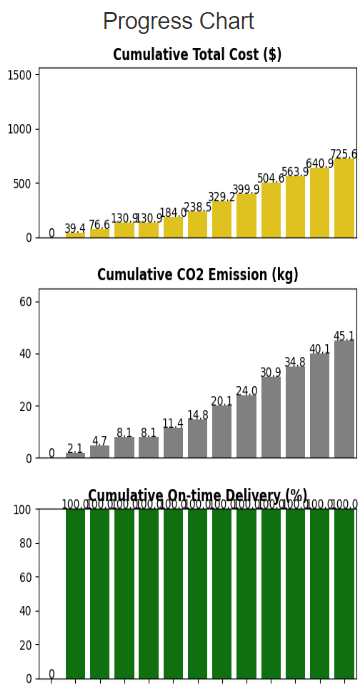


```
Period:3,Route:A4:1
Period:3,Route:B3:1
Period:3,Route:C2:1
Order:1[Q=4],Region:C,Period:3[1,4],Route:C2
Order:2[Q=5],Region:C,Period:3[1,3],Route:C2
Order:5[Q=1],Region:A,Period:3[1,4],Route:A4
Order:6[Q=1],Region:A,Period:3[1,3],Route:A4
Order:11[Q=5],Region:A,Period:3[2,5],Route:A4
Order:12[Q=4],Region:B,Period:3[2,4],Route:B3
Order:13[Q=4],Region:B,Period:3[2,3],Route:B3
Order:14[Q=2],Region:B,Period:3[2,5],Route:B3
Order:20[Q=2],Region:A,Period:3[3,4],Route:A4
Period:4,Route:CD3:1
Order:10[Q=3],Region:C,Period:4[2,4],Route:CD3
Order:16[Q=3],Region:D,Period:4[2,8],Route:CD3
Order:21[Q=3],Region:D,Period:4[3,9],Route:CD3
Period:5,Route:A3:1
Period:5,Route:B2:1
Period:5,Route:B3:1
Period:5,Route:AB3:1
Order:4[Q=3],Region:A,Period:5[1,5],Route:AB3
Order:7[Q=5],Region:A,Period:5[2,5],Route:A3
Order:15[Q=3],Region:B,Period:5[2,5],Route:B3
Order:19[Q=4],Region:B,Period:5[3,5],Route:B2
Order:23[Q=2],Region:B,Period:5[4,6],Route:AB3
Order:24[Q=3],Region:B,Period:5[4,7],Route:B3
Order:31[Q=5],Region:B,Period:5[5,8],Route:B2
Order:32[Q=4],Region:B,Period:5[5,10],Route:AB3
Order:33[Q=3],Region:B,Period:5[5,11],Route:B3
Order:34[Q=3],Region:A,Period:5[5,11],Route:A3
Order:36[Q=1],Region:A,Period:5[5,8],Route:A3
Period:6,Route:B2:1
Period:6,Route:C4:1
Period:6,Route:D3:1
Order:3[Q=5],Region:B,Period:6[1,6],Route:B2
Order:17[Q=4],Region:B,Period:6[2,6],Route:B2
Order:18[Q=2],Region:C,Period:6[2,7],Route:C4
Order:26[Q=2],Region:C,Period:6[5,6],Route:C4
Order:28[Q=3],Region:C,Period:6[5,11],Route:C4
Order:30[Q=1],Region:D,Period:6[5,6],Route:D3
Order:38[Q=5],Region:D,Period:6[6,9],Route:D3
Order:39[Q=2],Region:C,Period:6[6,9],Route:C4
Order:43[Q=3],Region:D,Period:6[6,7],Route:D3
Period:7,Route:A2:1
Period:7,Route:B2:1
Period:7,Route:C2:1
Order:8[Q=5],Region:C,Period:7[2,7],Route:C2
Order:9[Q=4],Region:C,Period:7[2,7],Route:C2
Order:27[Q=5],Region:B,Period:7[5,7],Route:B2
Order:37[Q=4],Region:A,Period:7[6,7],Route:A2
Order:40[Q=5],Region:A,Period:7[6,7],Route:A2
Order:41[Q=5],Region:B,Period:7[6,7],Route:B2
Period:8,Route:A3:1
Period:8,Route:B2:1
Period:8,Route:B5:1
Period:8,Route:C2:1
Period:8,Route:C3:1
Period:8,Route:D3:1
Order:22[Q=2],Region:B,Period:8[4,8],Route:B5
Order:29[Q=3],Region:B,Period:8[5,10],Route:B5
Order:35[Q=4],Region:B,Period:8[5,8],Route:B2
Order:42[Q=1],Region:B,Period:8[6,8],Route:B5
Order:44[Q=2],Region:A,Period:8[7,8],Route:A3
Order:46[Q=3],Region:C,Period:8[7,11],Route:C3
Order:48[Q=3],Region:D,Period:8[7,8],Route:D3
Order:49[Q=5],Region:B,Period:8[7,9],Route:B2
Order:50[Q=3],Region:B,Period:8[7,9],Route:B5
Order:54[Q=2],Region:D,Period:8[7,11],Route:D3
Order:58[Q=5],Region:C,Period:8[7,8],Route:C2
Order:60[Q=1],Region:B,Period:8[8,13],Route:B5
Order:67[Q=4],Region:D,Period:8[8,10],Route:D3
Order:69[Q=5],Region:C,Period:8[8,9],Route:C2
Order:70[Q=2],Region:A,Period:8[8,13],Route:A3
Order:72[Q=3],Region:C,Period:8[8,13],Route:C3
Order:73[Q=5],Region:A,Period:8[8,9],Route:A3
Order:74[Q=4],Region:C,Period:8[8,12],Route:C3
Period:9,Route:C5:1
Period:9,Route:F3:1
Order:52[Q=1],Region:C,Period:9[7,10],Route:C5
Order:55[Q=1],Region:C,Period:9[7,9],Route:C5
Order:57[Q=2],Region:C,Period:9[7,11],Route:C5
Order:66[Q=4],Region:C,Period:9[8,12],Route:C5
Order:68[Q=2],Region:C,Period:9[8,11],Route:C5
Order:77[Q=2],Region:F,Period:9[9,10],Route:F3
Order:79[Q=4],Region:F,Period:9[9,11],Route:F3
Order:81[Q=4],Region:F,Period:9[9,12],Route:F3
Period:10,Route:A3:1
Period:10,Route:B2:1
Period:10,Route:C2:1
Period:10,Route:D2:1
Period:10,Route:G3:1
Period:10,Route:FG3:1
Order:25[Q=3],Region:A,Period:10[5,10],Route:A3
Order:51[Q=5],Region:B,Period:10[7,10],Route:B2
Order:53[Q=5],Region:D,Period:10[7,11],Route:D2
Order:59[Q=4],Region:C,Period:10[8,10],Route:C2
Order:61[Q=3],Region:A,Period:10[8,11],Route:A3
Order:62[Q=3],Region:A,Period:10[8,13],Route:A3
Order:63[Q=4],Region:B,Period:10[8,13],Route:B2
Order:64[Q=4],Region:D,Period:10[8,10],Route:D2
Order:65[Q=5],Region:C,Period:10[8,10],Route:C2
Order:75[Q=1],Region:G,Period:10[9,10],Route:G3
Order:76[Q=2],Region:F,Period:10[9,10],Route:FG3
Order:80[Q=3],Region:G,Period:10[9,10],Route:FG3
Order:82[Q=4],Region:G,Period:10[9,13],Route:G3
Order:83[Q=4],Region:F,Period:10[10,11],Route:FG3
Order:84[Q=5],Region:G,Period:10[10,13],Route:G3
Period:11,Route:D2:1
Period:11,Route:E2:1
Period:11,Route:E5:1
Period:11,Route:F3:1
Period:11,Route:F5:1
Period:11,Route:G4:1
Period:11,Route:EF3:1
Order:45[Q=5],Region:D,Period:11[7,11],Route:D2
Order:71[Q=4],Region:D,Period:11[8,12],Route:D2
Order:78[Q=1],Region:E,Period:11[9,11],Route:E5
Order:85[Q=1],Region:F,Period:11[10,13],Route:F5
Order:86[Q=3],Region:G,Period:11[11,12],Route:G4
Order:87[Q=3],Region:F,Period:11[11,12],Route:F5
Order:90[Q=5],Region:E,Period:11[11,11],Route:E2
Order:91[Q=2],Region:E,Period:11[11,13],Route:EF3
Order:92[Q=1],Region:F,Period:11[11,13],Route:F5
Order:93[Q=1],Region:E,Period:11[11,12],Route:E5
Order:94[Q=1],Region:G,Period:11[11,13],Route:G4
Order:95[Q=3],Region:F,Period:11[11,12],Route:EF3
Order:96[Q=3],Region:F,Period:11[11,11],Route:F3
Order:97[Q=2],Region:G,Period:11[11,13],Route:G4
Order:103[Q=3],Region:F,Period:11[11,11],Route:F3
Order:104[Q=4],Region:E,Period:11[11,13],Route:EF3
Order:105[Q=1],Region:F,Period:11[11,13],Route:F5
Order:106[Q=4],Region:E,Period:11[11,12],Route:E2
Order:107[Q=4],Region:G,Period:11[11,13],Route:G4
Order:108[Q=2],Region:E,Period:11[11,13],Route:E5
Order:109[Q=2],Region:E,Period:11[11,11],Route:E5
Order:110[Q=3],Region:F,Period:11[11,13],Route:F3
Order:111[Q=3],Region:E,Period:11[11,11],Route:E5
Order:115[Q=3],Region:F,Period:11[11,13],Route:F5
Period:12,Route:E2:1
Order:99[Q=5],Region:E,Period:12[11,13],Route:E2
Order:100[Q=4],Region:E,Period:12[11,13],Route:E2
Period:13,Route:B2:1
Period:13,Route:E2:1
Period:13,Route:E4:1
Period:13,Route:F2:1
Period:13,Route:G2:1
Period:13,Route:G3:1
Order:47[Q=5],Region:B,Period:13[7,13],Route:B2
Order:56[Q=4],Region:B,Period:13[7,13],Route:B2
Order:88[Q=5],Region:E,Period:13[11,13],Route:E2
Order:89[Q=1],Region:G,Period:13[11,13],Route:G3
Order:98[Q=5],Region:G,Period:13[11,13],Route:G3
Order:101[Q=4],Region:G,Period:13[11,13],Route:G3
Order:102[Q=3],Region:E,Period:13[11,13],Route:E4
Order:112[Q=4],Region:G,Period:13[11,13],Route:G2
Order:113[Q=5],Region:G,Period:13[11,13],Route:G2
Order:114[Q=5],Region:F,Period:13[11,13],Route:F2
Order:116[Q=4],Region:E,Period:13[12,13],Route:E2
Order:117[Q=2],Region:E,Period:13[12,13],Route:E4
Order:118[Q=5],Region:F,Period:13[13,13],Route:F2
Order:119[Q=2],Region:E,Period:13[13,13],Route:E4
Order:120[Q=2],Region:E,Period:13[13,13],Route:E4
```

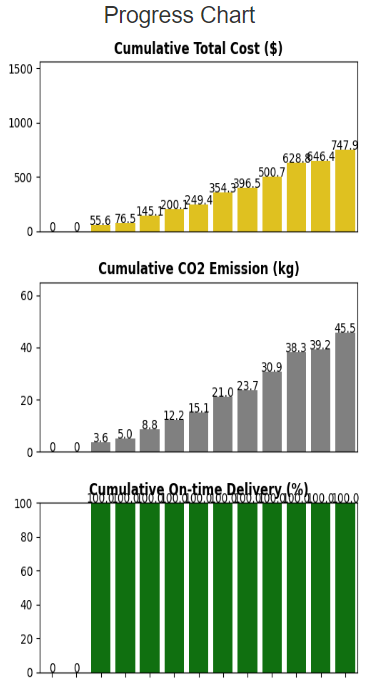

```
Period:1,Route:C2:1
Order:1[Q=4],Region:C,Period:1[1,4],Route:C2
Order:2[Q=5],Region:C,Period:1[1,3],Route:C2
Period:3,Route:A4:1
Period:3,Route:B3:1
Period:3,Route:C2:1
Order:4[Q=3],Region:A,Period:3[1,5],Route:A4
Order:5[Q=1],Region:A,Period:3[1,4],Route:A4
Order:6[Q=1],Region:A,Period:3[1,3],Route:A4
Order:9[Q=4],Region:C,Period:3[2,7],Route:C2
Order:10[Q=3],Region:C,Period:3[2,4],Route:C2
Order:13[Q=4],Region:B,Period:3[2,3],Route:B3
Order:14[Q=2],Region:B,Period:3[2,5],Route:B3
Order:19[Q=4],Region:B,Period:3[3,5],Route:B3
Order:20[Q=2],Region:A,Period:3[3,4],Route:A4
Period:4,Route:A2:1
Period:4,Route:B3:1
Order:7[Q=5],Region:A,Period:4[2,5],Route:A2
Order:11[Q=5],Region:A,Period:4[2,5],Route:A2
Order:12[Q=4],Region:B,Period:4[2,4],Route:B3
Order:17[Q=4],Region:B,Period:4[2,6],Route:B3
Order:22[Q=2],Region:B,Period:4[4,8],Route:B3
Period:5,Route:B3:1
Period:5,Route:C2:1
Order:8[Q=5],Region:C,Period:5[2,7],Route:C2
Order:15[Q=3],Region:B,Period:5[2,5],Route:B3
Order:24[Q=3],Region:B,Period:5[4,7],Route:B3
Order:26[Q=2],Region:C,Period:5[5,6],Route:C2
Order:35[Q=4],Region:B,Period:5[5,8],Route:B3
Period:6,Route:B2:1
Period:6,Route:B3:1
Period:6,Route:D4:1
Order:3[Q=5],Region:B,Period:6[1,6],Route:B3
Order:16[Q=3],Region:D,Period:6[2,8],Route:D4
Order:21[Q=3],Region:D,Period:6[3,9],Route:D4
Order:23[Q=2],Region:B,Period:6[4,6],Route:B3
Order:27[Q=5],Region:B,Period:6[5,7],Route:B2
Order:30[Q=1],Region:D,Period:6[5,6],Route:D4
Order:31[Q=5],Region:B,Period:6[5,8],Route:B2
Order:33[Q=3],Region:B,Period:6[5,11],Route:B3
Order:43[Q=3],Region:D,Period:6[6,7],Route:D4
Period:7,Route:A2:1
Period:7,Route:A4:1
Period:7,Route:B2:1
Period:7,Route:B3:1
Period:7,Route:C4:1
Period:7,Route:D2:1
Order:18[Q=2],Region:C,Period:7[2,7],Route:C4
Order:25[Q=3],Region:A,Period:7[5,10],Route:A4
Order:28[Q=3],Region:C,Period:7[5,11],Route:C4
Order:29[Q=3],Region:B,Period:7[5,10],Route:B3
Order:32[Q=4],Region:B,Period:7[5,10],Route:B3
Order:34[Q=3],Region:A,Period:7[5,11],Route:A4
Order:36[Q=1],Region:A,Period:7[5,8],Route:A4
Order:37[Q=4],Region:A,Period:7[6,7],Route:A2
Order:39[Q=2],Region:C,Period:7[6,9],Route:C4
Order:40[Q=5],Region:A,Period:7[6,7],Route:A2
Order:41[Q=5],Region:B,Period:7[6,7],Route:B2
Order:44[Q=2],Region:A,Period:7[7,8],Route:A4
Order:45[Q=5],Region:D,Period:7[7,11],Route:D2
Order:46[Q=3],Region:C,Period:7[7,11],Route:C4
Order:49[Q=5],Region:B,Period:7[7,9],Route:B2
Order:50[Q=3],Region:B,Period:7[7,9],Route:B3
Order:53[Q=5],Region:D,Period:7[7,11],Route:D2
Period:8,Route:A2:1
Period:8,Route:B4:1
Period:8,Route:C2:1
Period:8,Route:D2:1
Order:38[Q=5],Region:D,Period:8[6,9],Route:D2
Order:42[Q=1],Region:B,Period:8[6,8],Route:B4
Order:48[Q=3],Region:D,Period:8[7,8],Route:D2
Order:56[Q=4],Region:B,Period:8[7,13],Route:B4
Order:58[Q=5],Region:C,Period:8[7,8],Route:C2
Order:60[Q=1],Region:B,Period:8[8,13],Route:B4
Order:61[Q=3],Region:A,Period:8[8,11],Route:A2
Order:63[Q=4],Region:B,Period:8[8,13],Route:B4
Order:69[Q=5],Region:C,Period:8[8,9],Route:C2
Order:73[Q=5],Region:A,Period:8[8,9],Route:A2
Period:9,Route:C2:1
Period:9,Route:C5:1
Period:9,Route:D2:1
Order:52[Q=1],Region:C,Period:9[7,10],Route:C5
Order:55[Q=1],Region:C,Period:9[7,9],Route:C5
Order:57[Q=2],Region:C,Period:9[7,11],Route:C5
Order:59[Q=4],Region:C,Period:9[8,10],Route:C2
Order:64[Q=4],Region:D,Period:9[8,10],Route:D2
Order:66[Q=4],Region:C,Period:9[8,12],Route:C5
Order:67[Q=4],Region:D,Period:9[8,10],Route:D2
Order:68[Q=2],Region:C,Period:9[8,11],Route:C5
Order:72[Q=3],Region:C,Period:9[8,13],Route:C2
Period:10,Route:B2:1
Period:10,Route:C2:1
Period:10,Route:F2:1
Period:10,Route:F4:1
Period:10,Route:G2:1
Order:47[Q=5],Region:B,Period:10[7,13],Route:B2
Order:51[Q=5],Region:B,Period:10[7,10],Route:B2
Order:65[Q=5],Region:C,Period:10[8,10],Route:C2
Order:74[Q=4],Region:C,Period:10[8,12],Route:C2
Order:75[Q=1],Region:G,Period:10[9,10],Route:G2
Order:76[Q=2],Region:F,Period:10[9,10],Route:F4
Order:77[Q=2],Region:F,Period:10[9,10],Route:F4
Order:79[Q=4],Region:F,Period:10[9,11],Route:F2
Order:80[Q=3],Region:G,Period:10[9,10],Route:G2
Order:81[Q=4],Region:F,Period:10[9,12],Route:F2
Order:83[Q=4],Region:F,Period:10[10,11],Route:F4
Order:85[Q=1],Region:F,Period:10[10,13],Route:F4
Period:11,Route:D2:1
Period:11,Route:E2:1
Period:11,Route:E3:1
Period:11,Route:E5:1
Period:11,Route:F4:1
Period:11,Route:G4:1
Order:54[Q=2],Region:D,Period:11[7,11],Route:D2
Order:71[Q=4],Region:D,Period:11[8,12],Route:D2
Order:78[Q=1],Region:E,Period:11[9,11],Route:E5
Order:86[Q=3],Region:G,Period:11[11,12],Route:G4
Order:89[Q=1],Region:G,Period:11[11,13],Route:G4
Order:90[Q=5],Region:E,Period:11[11,11],Route:E2
Order:92[Q=1],Region:F,Period:11[11,13],Route:F4
Order:93[Q=1],Region:E,Period:11[11,12],Route:E5
Order:94[Q=1],Region:G,Period:11[11,13],Route:G4
Order:96[Q=3],Region:F,Period:11[11,11],Route:F4
Order:99[Q=5],Region:E,Period:11[11,13],Route:E2
Order:100[Q=4],Region:E,Period:11[11,13],Route:E3
Order:102[Q=3],Region:E,Period:11[11,13],Route:E5
Order:103[Q=3],Region:F,Period:11[11,11],Route:F4
Order:106[Q=4],Region:E,Period:11[11,12],Route:E3
Order:108[Q=2],Region:E,Period:11[11,13],Route:E5
Order:109[Q=2],Region:E,Period:11[11,11],Route:E3
Order:111[Q=3],Region:E,Period:11[11,11],Route:E5
Order:113[Q=5],Region:G,Period:11[11,13],Route:G4
Order:115[Q=3],Region:F,Period:11[11,13],Route:F4
Period:12,Route:A2:1
Period:12,Route:E2:1
Period:12,Route:E3:1
Period:12,Route:F4:1
Period:12,Route:G2:1
Period:12,Route:G3:1
Order:62[Q=3],Region:A,Period:12[8,13],Route:A2
Order:70[Q=2],Region:A,Period:12[8,13],Route:A2
Order:82[Q=4],Region:G,Period:12[9,13],Route:G3
Order:84[Q=5],Region:G,Period:12[10,13],Route:G2
Order:87[Q=3],Region:F,Period:12[11,12],Route:F4
Order:88[Q=5],Region:E,Period:12[11,13],Route:E2
Order:91[Q=2],Region:E,Period:12[11,13],Route:E3
Order:95[Q=3],Region:F,Period:12[11,12],Route:F4
Order:97[Q=2],Region:G,Period:12[11,13],Route:G3
Order:101[Q=4],Region:G,Period:12[11,13],Route:G2
Order:104[Q=4],Region:E,Period:12[11,13],Route:E3
Order:105[Q=1],Region:F,Period:12[11,13],Route:F4
Order:110[Q=3],Region:F,Period:12[11,13],Route:F4
Order:112[Q=4],Region:G,Period:12[11,13],Route:G3
Order:116[Q=4],Region:E,Period:12[12,13],Route:E2
Order:117[Q=2],Region:E,Period:12[12,13],Route:E3
Period:13,Route:E2:1
Period:13,Route:F2:1
Period:13,Route:G2:1
Order:98[Q=5],Region:G,Period:13[11,13],Route:G2
Order:107[Q=4],Region:G,Period:13[11,13],Route:G2
Order:114[Q=5],Region:F,Period:13[11,13],Route:F2
Order:118[Q=5],Region:F,Period:13[13,13],Route:F2
Order:119[Q=2],Region:E,Period:13[13,13],Route:E2
Order:120[Q=2],Region:E,Period:13[13,13],Route:E2


```


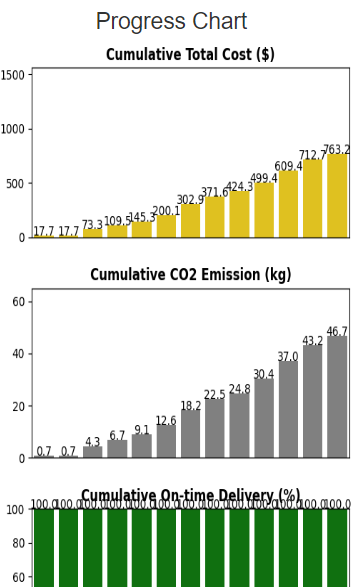

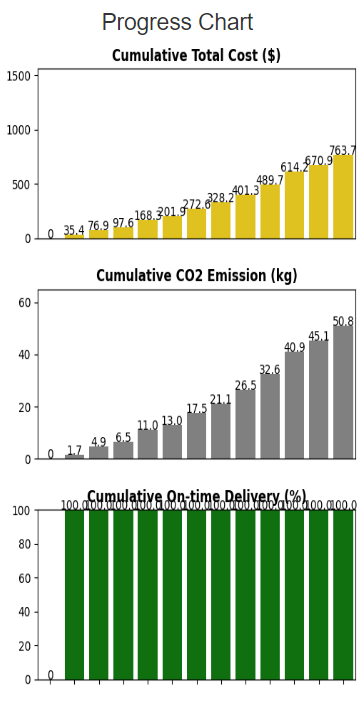

```
Objective= 60999.0
Period:2,Route:A3:1
Period:2,Route:C3:1
Order:2[Q=5],Region:C,Period:2[1,3],Route:C3
Order:5[Q=1],Region:A,Period:2[1,4],Route:A3
Order:10[Q=3],Region:C,Period:2[2,4],Route:C3
Order:11[Q=5],Region:A,Period:2[2,5],Route:A3
Order:18[Q=2],Region:C,Period:2[2,7],Route:C3
Period:3,Route:A3:1
Period:3,Route:B3:1
Period:3,Route:C3:1
Order:1[Q=4],Region:C,Period:3[1,4],Route:C3
Order:4[Q=3],Region:A,Period:3[1,5],Route:A3
Order:6[Q=1],Region:A,Period:3[1,3],Route:A3
Order:13[Q=4],Region:B,Period:3[2,3],Route:B3
Order:14[Q=2],Region:B,Period:3[2,5],Route:B3
Order:19[Q=4],Region:B,Period:3[3,5],Route:B3
Order:20[Q=2],Region:A,Period:3[3,4],Route:A3
Period:4,Route:B3:1
Order:12[Q=4],Region:B,Period:4[2,4],Route:B3
Order:17[Q=4],Region:B,Period:4[2,6],Route:B3
Order:23[Q=2],Region:B,Period:4[4,6],Route:B3
Period:5,Route:A3:1
Period:5,Route:B3:1
Period:5,Route:C3:1
Period:5,Route:D3:1
Order:7[Q=5],Region:A,Period:5[2,5],Route:A3
Order:9[Q=4],Region:C,Period:5[2,7],Route:C3
Order:15[Q=3],Region:B,Period:5[2,5],Route:B3
Order:21[Q=3],Region:D,Period:5[3,9],Route:D3
Order:24[Q=3],Region:B,Period:5[4,7],Route:B3
Order:25[Q=3],Region:A,Period:5[5,10],Route:A3
Order:26[Q=2],Region:C,Period:5[5,6],Route:C3
Order:28[Q=3],Region:C,Period:5[5,11],Route:C3
Order:30[Q=1],Region:D,Period:5[5,6],Route:D3
Order:35[Q=4],Region:B,Period:5[5,8],Route:B3
Order:36[Q=1],Region:A,Period:5[5,8],Route:A3
Period:6,Route:B3:1
Period:6,Route:C3:1
Order:3[Q=5],Region:B,Period:6[1,6],Route:B3
Order:8[Q=5],Region:C,Period:6[2,7],Route:C3
Order:39[Q=2],Region:C,Period:6[6,9],Route:C3
Order:41[Q=5],Region:B,Period:6[6,7],Route:B3
Period:7,Route:A3:1
Period:7,Route:B3:1
Period:7,Route:C3:1
Period:7,Route:D3:1
Order:16[Q=3],Region:D,Period:7[2,8],Route:D3
Order:27[Q=5],Region:B,Period:7[5,7],Route:B3
Order:37[Q=4],Region:A,Period:7[6,7],Route:A3
Order:40[Q=5],Region:A,Period:7[6,7],Route:A3
Order:42[Q=1],Region:B,Period:7[6,8],Route:B3
Order:43[Q=3],Region:D,Period:7[6,7],Route:D3
Order:46[Q=3],Region:C,Period:7[7,11],Route:C3
Order:48[Q=3],Region:D,Period:7[7,8],Route:D3
Order:56[Q=4],Region:B,Period:7[7,13],Route:B3
Order:57[Q=2],Region:C,Period:7[7,11],Route:C3
Order:58[Q=5],Region:C,Period:7[7,8],Route:C3
Period:8,Route:A3:1
Period:8,Route:B3:1
Period:8,Route:C3:1
Order:22[Q=2],Region:B,Period:8[4,8],Route:B3
Order:31[Q=5],Region:B,Period:8[5,8],Route:B3
Order:44[Q=2],Region:A,Period:8[7,8],Route:A3
Order:50[Q=3],Region:B,Period:8[7,9],Route:B3
Order:52[Q=1],Region:C,Period:8[7,10],Route:C3
Order:61[Q=3],Region:A,Period:8[8,11],Route:A3
Order:69[Q=5],Region:C,Period:8[8,9],Route:C3
Order:73[Q=5],Region:A,Period:8[8,9],Route:A3
Order:74[Q=4],Region:C,Period:8[8,12],Route:C3
Period:9,Route:B3:1
Period:9,Route:C3:1
Period:9,Route:D3:1
Period:9,Route:E3:1
Period:9,Route:G3:1
Order:38[Q=5],Region:D,Period:9[6,9],Route:D3
Order:49[Q=5],Region:B,Period:9[7,9],Route:B3
Order:51[Q=5],Region:B,Period:9[7,10],Route:B3
Order:55[Q=1],Region:C,Period:9[7,9],Route:C3
Order:65[Q=5],Region:C,Period:9[8,10],Route:C3
Order:71[Q=4],Region:D,Period:9[8,12],Route:D3
Order:72[Q=3],Region:C,Period:9[8,13],Route:C3
Order:75[Q=1],Region:G,Period:9[9,10],Route:G3
Order:78[Q=1],Region:E,Period:9[9,11],Route:E3
Order:80[Q=3],Region:G,Period:9[9,10],Route:G3
Order:82[Q=4],Region:G,Period:9[9,13],Route:G3
Period:10,Route:B3:1
Period:10,Route:C3:1
Period:10,Route:D3:1
Period:10,Route:F3:1
Period:10,Route:G3:1
Order:29[Q=3],Region:B,Period:10[5,10],Route:B3
Order:32[Q=4],Region:B,Period:10[5,10],Route:B3
Order:33[Q=3],Region:B,Period:10[5,11],Route:B3
Order:54[Q=2],Region:D,Period:10[7,11],Route:D3
Order:59[Q=4],Region:C,Period:10[8,10],Route:C3
Order:64[Q=4],Region:D,Period:10[8,10],Route:D3
Order:66[Q=4],Region:C,Period:10[8,12],Route:C3
Order:67[Q=4],Region:D,Period:10[8,10],Route:D3
Order:68[Q=2],Region:C,Period:10[8,11],Route:C3
Order:76[Q=2],Region:F,Period:10[9,10],Route:F3
Order:77[Q=2],Region:F,Period:10[9,10],Route:F3
Order:79[Q=4],Region:F,Period:10[9,11],Route:F3
Order:84[Q=5],Region:G,Period:10[10,13],Route:G3
Period:11,Route:A3:1
Period:11,Route:B3:1
Period:11,Route:D3:1
Period:11,Route:E3:1
Period:11,Route:E4:1
Period:11,Route:F3:1
Period:11,Route:G3:1
Order:34[Q=3],Region:A,Period:11[5,11],Route:A3
Order:45[Q=5],Region:D,Period:11[7,11],Route:D3
Order:47[Q=5],Region:B,Period:11[7,13],Route:B3
Order:53[Q=5],Region:D,Period:11[7,11],Route:D3
Order:60[Q=1],Region:B,Period:11[8,13],Route:B3
Order:62[Q=3],Region:A,Period:11[8,13],Route:A3
Order:63[Q=4],Region:B,Period:11[8,13],Route:B3
Order:70[Q=2],Region:A,Period:11[8,13],Route:A3
Order:83[Q=4],Region:F,Period:11[10,11],Route:F3
Order:86[Q=3],Region:G,Period:11[11,12],Route:G3
Order:90[Q=5],Region:E,Period:11[11,11],Route:E4
Order:93[Q=1],Region:E,Period:11[11,12],Route:E3
Order:94[Q=1],Region:G,Period:11[11,13],Route:G3
Order:96[Q=3],Region:F,Period:11[11,11],Route:F3
Order:98[Q=5],Region:G,Period:11[11,13],Route:G3
Order:99[Q=5],Region:E,Period:11[11,13],Route:E3
Order:103[Q=3],Region:F,Period:11[11,11],Route:F3
Order:106[Q=4],Region:E,Period:11[11,12],Route:E3
Order:109[Q=2],Region:E,Period:11[11,11],Route:E4
Order:111[Q=3],Region:E,Period:11[11,11],Route:E4
Period:12,Route:E3:1
Period:12,Route:F3:1
Period:12,Route:G3:1
Order:81[Q=4],Region:F,Period:12[9,12],Route:F3
Order:87[Q=3],Region:F,Period:12[11,12],Route:F3
Order:95[Q=3],Region:F,Period:12[11,12],Route:F3
Order:97[Q=2],Region:G,Period:12[11,13],Route:G3
Order:101[Q=4],Region:G,Period:12[11,13],Route:G3
Order:104[Q=4],Region:E,Period:12[11,13],Route:E3
Order:108[Q=2],Region:E,Period:12[11,13],Route:E3
Order:112[Q=4],Region:G,Period:12[11,13],Route:G3
Order:116[Q=4],Region:E,Period:12[12,13],Route:E3
Period:13,Route:E3:1
Period:13,Route:E4:1
Period:13,Route:F3:1
Period:13,Route:F4:1
Period:13,Route:G3:1
Order:85[Q=1],Region:F,Period:13[10,13],Route:F4
Order:88[Q=5],Region:E,Period:13[11,13],Route:E3
Order:89[Q=1],Region:G,Period:13[11,13],Route:G3
Order:91[Q=2],Region:E,Period:13[11,13],Route:E4
Order:92[Q=1],Region:F,Period:13[11,13],Route:F3
Order:100[Q=4],Region:E,Period:13[11,13],Route:E4
Order:102[Q=3],Region:E,Period:13[11,13],Route:E3
Order:105[Q=1],Region:F,Period:13[11,13],Route:F4
Order:107[Q=4],Region:G,Period:13[11,13],Route:G3
Order:110[Q=3],Region:F,Period:13[11,13],Route:F4
Order:113[Q=5],Region:G,Period:13[11,13],Route:G3
Order:114[Q=5],Region:F,Period:13[11,13],Route:F3
Order:115[Q=3],Region:F,Period:13[11,13],Route:F3
Order:117[Q=2],Region:E,Period:13[12,13],Route:E4
Order:118[Q=5],Region:F,Period:13[13,13],Route:F4
Order:119[Q=2],Region:E,Period:13[13,13],Route:E3
Order:120[Q=2],Region:E,Period:13[13,13],Route:E4
```